In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets
from sklearn.linear_model import LogisticRegression

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
dataset_orig = pd.read_csv('../../../data/adult.data.csv')

## Drop categorical features
dataset_orig = dataset_orig.drop(['fnlwgt','education'],axis=1)

## Drop NULL values
dataset_orig = dataset_orig.dropna()

## Change symbolics to numerics
dataset_orig['sex'] = np.where(dataset_orig['sex'] == ' Male', 1, 0)
dataset_orig['race'] = np.where(dataset_orig['race'] != ' White', 0, 1)
dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == ' <=50K', 0, 1)

non_numeric_columns = list(dataset_orig.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    dataset_orig[col] = le.fit_transform(dataset_orig[col])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2, shuffle = True)

(dataset_orig.head(5))

   LIMIT_BAL  sex  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   0.010101  0.0   0.333333  0.333333  0.051724    0.4    0.4    0.1    0.1   
1   0.111111  0.0   0.333333  0.666667  0.086207    0.1    0.4    0.2    0.2   
2   0.080808  0.0   0.333333  0.666667  0.224138    0.2    0.2    0.2    0.2   
3   0.040404  0.0   0.333333  0.333333  0.275862    0.2    0.2    0.2    0.2   
4   0.040404  1.0   0.333333  0.333333  0.620690    0.1    0.2    0.1    0.2   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0    0.0  ...   0.160138   0.080648   0.260979  0.000000  0.000409  0.000000   
1    0.2  ...   0.163220   0.084074   0.263485  0.000000  0.000594  0.001116   
2    0.2  ...   0.173637   0.095470   0.272928  0.001738  0.000891  0.001116   
3    0.2  ...   0.186809   0.109363   0.283685  0.002290  0.001199  0.001339   
4    0.2  ...   0.179863   0.099633   0.275681  0.002290  0.021779  0.011160   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  Proba

# Fairway

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = 'sex'

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=2)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']

dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig_train.groupby(dataset_orig_train[protected_attribute] == 0)]
dataset_orig_male[protected_attribute] = 0
X_train_male, y_train_male = dataset_orig_male.loc[:, dataset_orig_male.columns != 'Probability'], dataset_orig_male['Probability']
clf_male = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_male.fit(X_train_male, y_train_male)
X_train_female, y_train_female = dataset_orig_female.loc[:, dataset_orig_female.columns != 'Probability'], dataset_orig_female['Probability']
clf_female = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_female.fit(X_train_female, y_train_female)

for index,row in dataset_orig_train.iterrows():
    row_ = [row.values[0:len(row.values)-1]]
    y_male = clf_male.predict(row_)
    y_female = clf_female.predict(row_)
    if y_male[0] != y_female[0]:        
        dataset_orig_train = dataset_orig_train.drop(index)

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :sex 0.02
eod :sex 0.06
SPD: 0.03
DI: 0.34
aod :sex 0.01
eod :sex 0.03
SPD: 0.02
DI: 0.3


# Graph

In [10]:
causal_graph = """
digraph {
AGE;
sex;
MARRIAGE;
EDUCATION;
Probability;
U[label="Unobserved Confounders"];
sex -> Probability;
sex -> EDUCATION; EDUCATION -> Probability;
sex -> MARRIAGE; MARRIAGE -> Probability;
AGE -> EDUCATION; AGE -> MARRIAGE;
U->sex;U->Probability;
}
"""

## dowhy works for binary inputs only

dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == 0, False, True)
dataset_orig[protected_attribute] = np.where(dataset_orig[protected_attribute] == 1, True, False)

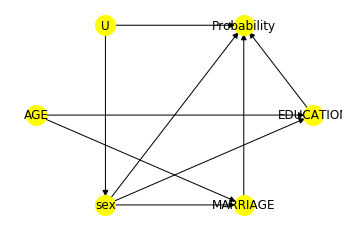

In [12]:
# With graph
model=CausalModel(
        data = dataset_orig,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [13]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|AGE))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,AGE,U) = P(Probability|sex,AGE)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [14]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|AGE))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,AGE,U) = P(Probability|sex,AGE)

## Realized estimand
b: Probability~sex+AGE
Target units: ate

## Estimate
Mean value: 0.035233180274654725

Causal Estimate is 0.035233180274654725


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [14]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.0333422742120271
New effect:0.03287378175953657



# Replace Treatment with Placebo

In [15]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.0333422742120271
New effect:4.6410318924799294e-05
p value:0.48



# Remove Random Subset of Data

In [16]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.0333422742120271
New effect:0.03301497992872545
p value:0.43999999999999995

